In [ ]:
import numpy as np
import pandas as pd
from math import sqrt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_read = pd.read_csv("/content/drive/MyDrive/immo_data.csv", engine='python', on_bad_lines='skip')


In [ ]:
cols = ["regio1","regio2","geo_plz","totalRent","livingSpace","noRooms","yearConstructed",
        "balcony","date","condition","interiorQual","typeOfFlat","heatingType","date","street"]

cols = list(dict.fromkeys(cols))  # entfernt Duplikate, behält Reihenfolge
df = df_read[cols].copy()



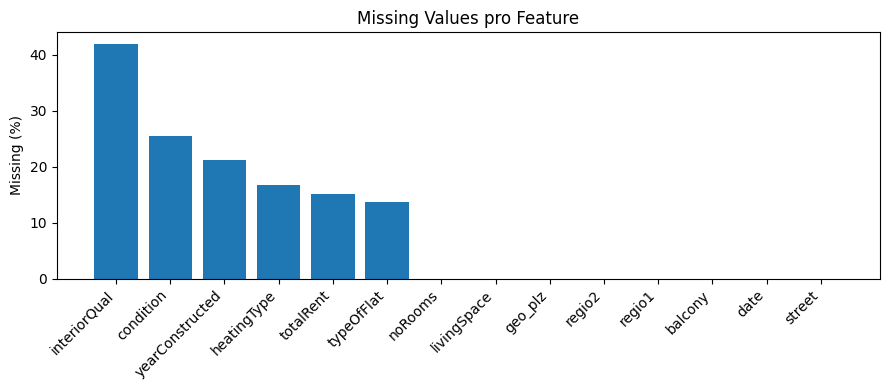

In [ ]:
import matplotlib.pyplot as plt

miss_pct = df.isna().mean().sort_values(ascending=False) * 100

plt.figure(figsize=(9,4))
plt.bar(miss_pct.index.astype(str), miss_pct.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing (%)")
plt.title("Missing Values pro Feature")
plt.tight_layout()
plt.show()


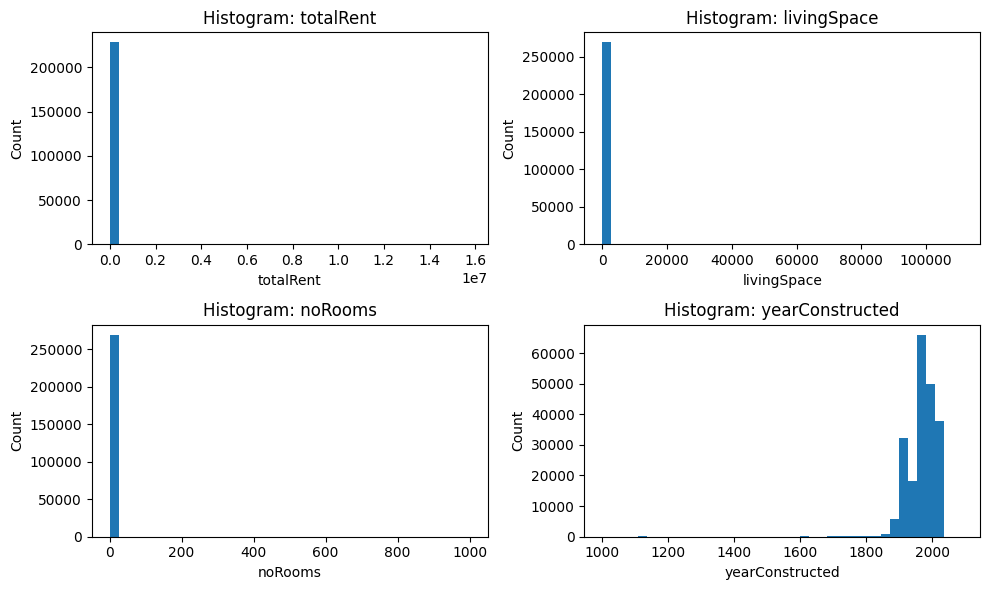

In [ ]:
num_plot_cols = [c for c in ["totalRent","livingSpace","noRooms","yearConstructed"] if c in df.columns]

fig = plt.figure(figsize=(10,6))
for i, c in enumerate(num_plot_cols, start=1):
    ax = plt.subplot(2, 2, i)
    x = df[c].dropna().values
    ax.hist(x, bins=40)
    ax.set_title(f"Histogram: {c}")
    ax.set_xlabel(c)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
df=df_read.copy()
cols = ["baseRent", "serviceCharge", "heatingCosts", "totalRent"]

# 1) sicher numeric machen (verhindert komische dtype-Probleme)
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 2) optionale Komponenten: NaN -> 0
df["serviceCharge"] = df["serviceCharge"].fillna(0)
df["heatingCosts"]  = df["heatingCosts"].fillna(0)

# 3) Maske: totalRent fehlt oder ist 0
mask_tr = df["totalRent"].isna() | df["totalRent"].eq(0)

# 4) Flag setzen (vorheriger Zustand)
df["totalRent_was_missing_or_zero"] = mask_tr.astype(int)

# 5) Imputation nur wenn baseRent vorhanden (sonst nicht sinnvoll)
mask_can = mask_tr & df["baseRent"].notna()

df.loc[mask_can, "totalRent"] = (
    df.loc[mask_can, "baseRent"]
    + df.loc[mask_can, "serviceCharge"]
    + df.loc[mask_can, "heatingCosts"]
)

# Kontrolle
print("totalRent NaN nachher:", df["totalRent"].isna().sum())
print("totalRent == 0 nachher:", df["totalRent"].eq(0).sum())
print("Imputed rows:", int(mask_can.sum()))
print("Still missing (baseRent missing):", int((mask_tr & ~df["baseRent"].notna()).sum()))

totalRent NaN nachher: 0
totalRent == 0 nachher: 23
Imputed rows: 40753
Still missing (baseRent missing): 0


In [ ]:
# 1) numeric cast (sicher)
for c in ["baseRent","serviceCharge","heatingCosts","totalRent"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Optional (empfohlen bei €): auf 2 Nachkommastellen standardisieren
# df[["baseRent","serviceCharge","heatingCosts","totalRent"]] = df[["baseRent","serviceCharge","heatingCosts","totalRent"]].round(2)

# 2) NaN -> 0 für service/heating (wie in deinem Check)
service0 = df["serviceCharge"].fillna(0)
heat0    = df["heatingCosts"].fillna(0)

# 3) Formeln
pred_B = df["baseRent"] + service0
pred_A = pred_B + heat0

# 4) erklärbar wenn A oder B exakt stimmt (und baseRent/totalRent vorhanden)
eval_mask = df["baseRent"].notna() & df["totalRent"].notna()
ok_B = eval_mask & (df["totalRent"] == pred_B)
ok_A = eval_mask & (df["totalRent"] == pred_A)

keep_mask = ok_A | ok_B          # erklärbar
drop_mask = eval_mask & ~keep_mask  # nicht erklärbar ("none")

# 5) Flag speichern (optional)
df["rent_explainable"] = keep_mask.astype(int)

# 6) Filtern
df_explainable = df.loc[keep_mask].copy()
df_removed     = df.loc[drop_mask].copy()

# 7) Report
n_all = len(df)
n_keep = int(keep_mask.sum())
n_drop = int(drop_mask.sum())

print("Rows total:", n_all)
print("Kept (explainable):", n_keep, f"({100*n_keep/n_all:.2f}%)")
print("Dropped (not explainable):", n_drop, f"({100*n_drop/n_all:.2f}%)")

# optional: sichern
# df_explainable.to_csv("df_explainable.csv", index=False)
# df_removed.to_csv("df_removed.csv", index=False)

Rows total: 268850
Kept (explainable): 240979 (89.63%)
Dropped (not explainable): 27871 (10.37%)


# Result hia li fiha NaNs o Zero

In [ ]:
cols = num_cols  # deine Liste
nan_count  = df_explainable[cols].isna().sum()
zero_count = (df_explainable[cols] == 0).sum(numeric_only=False)
result = pd.DataFrame({"NaN": nan_count, "0": zero_count})
result


,NaN,0
regio1,0,0
regio2,0,0
geo_plz,0,0
totalRent,0,23
livingSpace,0,67
noRooms,0,0
yearConstructed,51317,0
balcony,0,94743
date,0,0
condition,61609,0


Percentile baseRent um den totalRent zu Imputieren

In [ ]:

df_clean= df_explainable.copy()
current_year = 2026

mask_logic = (
    df_clean["totalRent"].between(200, 4000) &
    df_clean["livingSpace"].between(10, 300) &
    df_clean["noRooms"].between(1, 12) &
    (df_clean["yearConstructed"].between(1700, current_year) | df_clean["yearConstructed"].isna())
)

df_logic = df_clean.loc[mask_logic].copy()

print("Vorher:", len(df_clean),
      "Nach Logik-Filter:", len(df_logic),
      "Gelöscht:", len(df_clean)-len(df_logic),
      f"({(len(df_clean)-len(df_logic))/len(df_clean)*100:.2f}%)")

Vorher: 240979 Nach Logik-Filter: 239209 Gelöscht: 1770 (0.73%)


In [ ]:
cols = num_cols  # deine Liste
nan_count  = df_logic[cols].isna().sum()
zero_count = (df_logic[cols] == 0).sum(numeric_only=False)
result = pd.DataFrame({"NaN": nan_count, "0": zero_count})
result

,NaN,0
regio1,0,0
regio2,0,0
geo_plz,0,0
totalRent,0,0
livingSpace,0,0
noRooms,0,0
yearConstructed,50987,0
balcony,0,93919
date,0,0
condition,61107,0


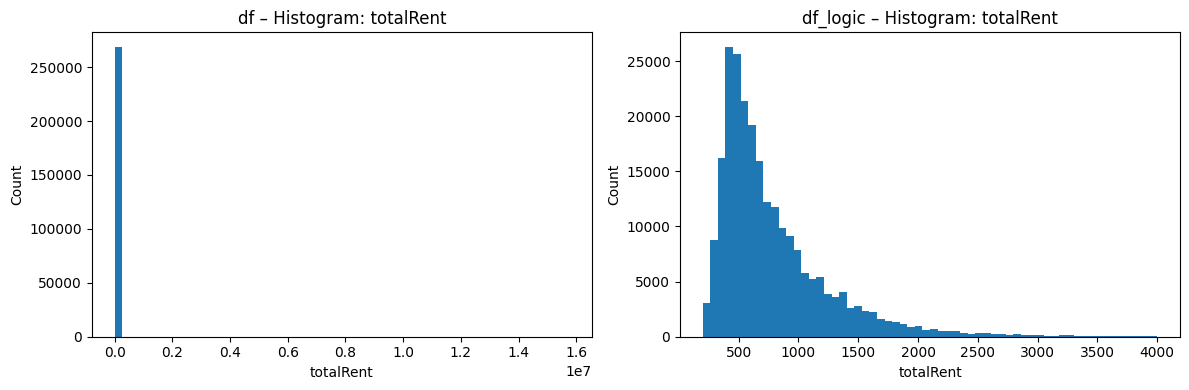

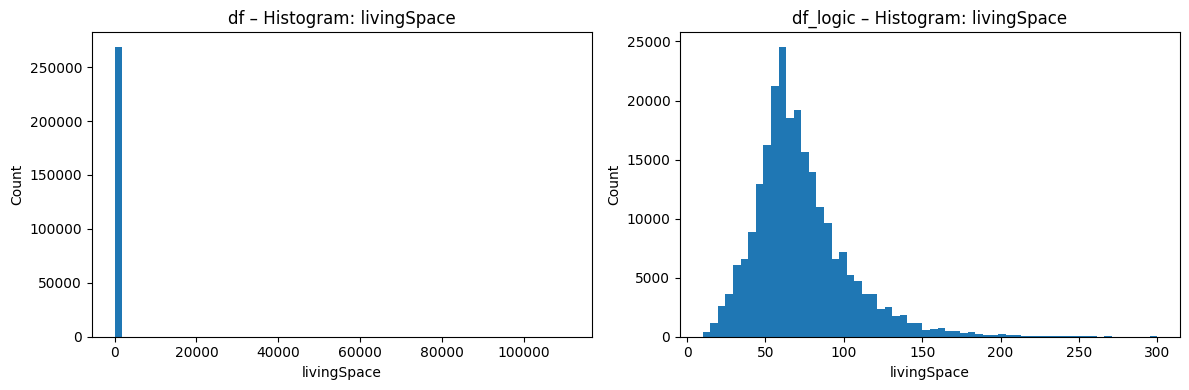

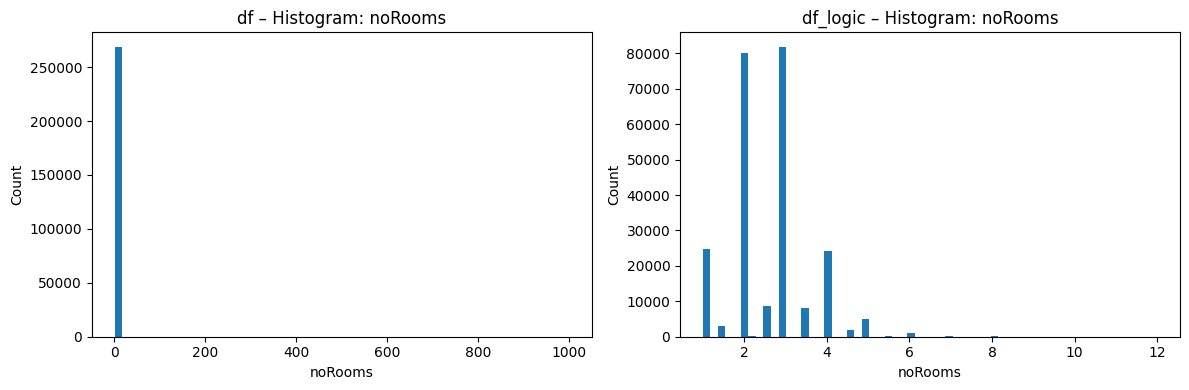

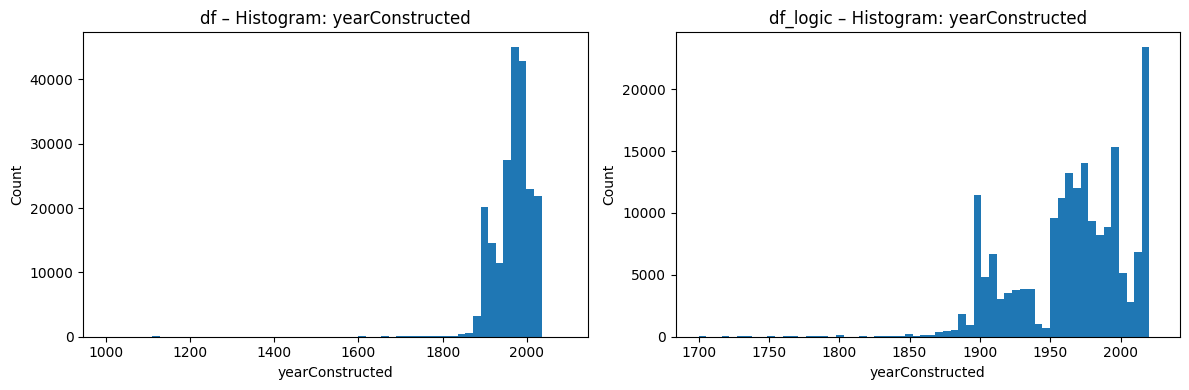

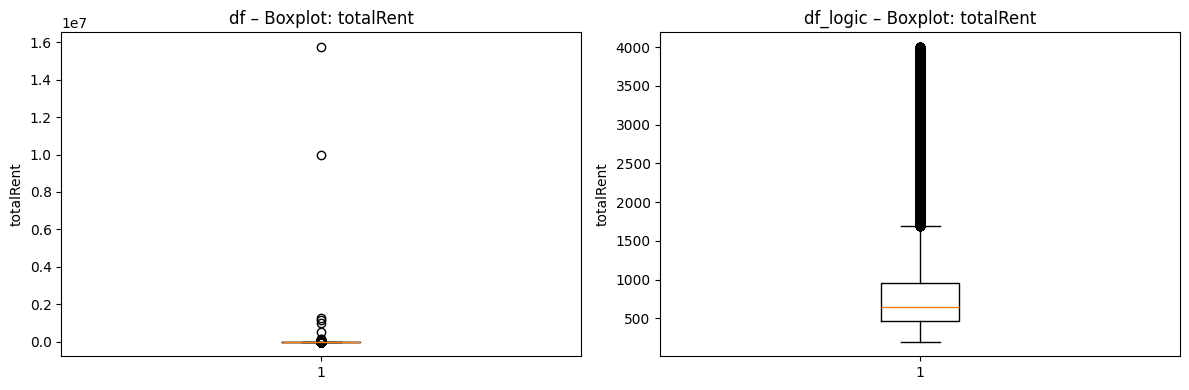

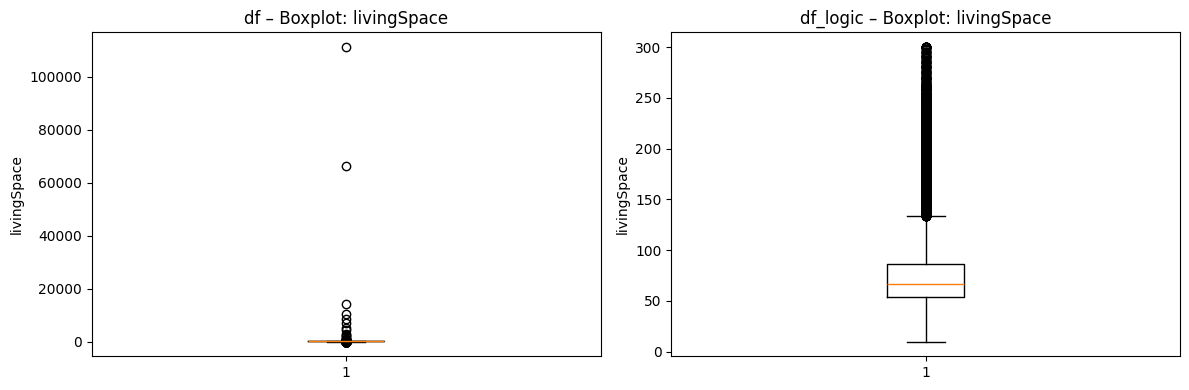

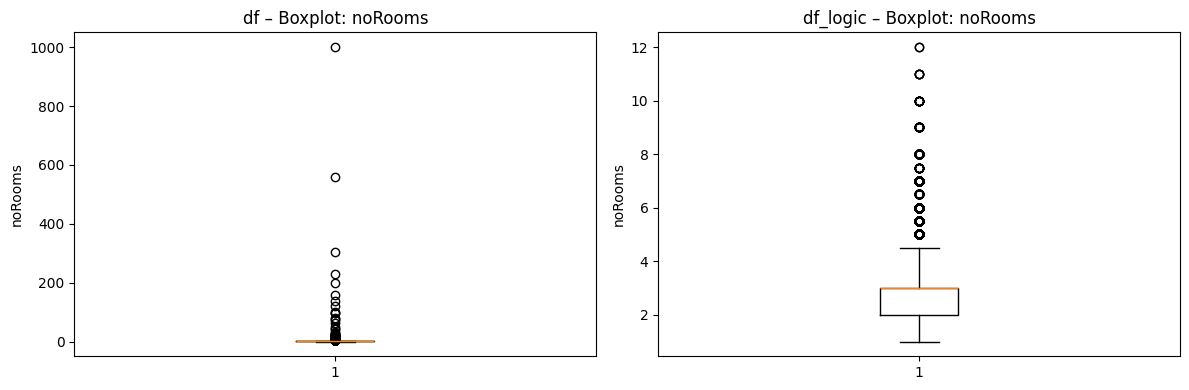

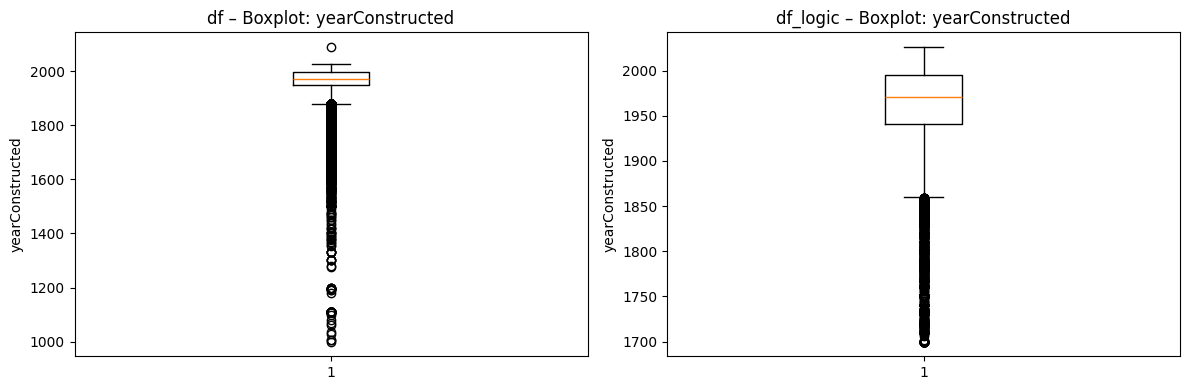

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Falls dein zweites DF df_logich heißt, nutze das statt df_logic
df2 = df_logic  # oder: df2 = df_logich

cols = ["totalRent", "livingSpace", "noRooms", "yearConstructed"]

def _num(s):
    return pd.to_numeric(s, errors="coerce")

def hist_side_by_side(df1, df2, col, names=("df", "df_logic"), bins=60):
    x1 = _num(df1[col]).dropna()
    x2 = _num(df2[col]).dropna()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].hist(x1, bins=bins)
    ax[0].set_title(f"{names[0]} – Histogram: {col}")
    ax[0].set_xlabel(col); ax[0].set_ylabel("Count")

    ax[1].hist(x2, bins=bins)
    ax[1].set_title(f"{names[1]} – Histogram: {col}")
    ax[1].set_xlabel(col); ax[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

def box_side_by_side(df1, df2, col, names=("df", "df_logic"), showfliers=True):
    x1 = _num(df1[col]).dropna()
    x2 = _num(df2[col]).dropna()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].boxplot(x1, vert=True, showfliers=showfliers)
    ax[0].set_title(f"{names[0]} – Boxplot: {col}")
    ax[0].set_ylabel(col)

    ax[1].boxplot(x2, vert=True, showfliers=showfliers)
    ax[1].set_title(f"{names[1]} – Boxplot: {col}")
    ax[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()


# ============================
# RUN: erst Histogramme, dann Boxplots
# ============================

names = ("df", "df_logic")  # oder ("df", "df_logich")

for c in cols:
    if c in df.columns and c in df2.columns:
        hist_side_by_side(df, df2, c, names=names, bins=60)
    else:
        print(f"⚠️ Spalte fehlt in einem DF: {c}")

for c in cols:
    if c in df.columns and c in df2.columns:
        box_side_by_side(df, df2, c, names=names, showfliers=True)
    else:
        print(f"⚠️ Spalte fehlt in einem DF: {c}")



In [ ]:
df_logic["date"] = pd.to_datetime(df_logic["date"], errors="coerce", dayfirst=True)
origin = pd.Timestamp("2010-01-01")
df_logic["date_days"] = (df_logic["date"] - origin).dt.days





/tmp/ipython-input-2309281260.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_logic["date"] = pd.to_datetime(df_logic["date"], errors="coerce", dayfirst=True)


In [ ]:
df_logic["date_days"].head(10)

KeyError: 'date_days'

In [ ]:
num_cols = [
    # Ort
    'regio1', 'regio2', 'geo_plz',
    #  numerische Daten
    'livingSpace', 'noRooms', 'yearConstructed',
    # boolische Daten
    'hasKitchen', 'balcony', 'garden', 'cellar',
    # Kategorien
    'condition', 'interiorQual', 'typeOfFlat','heatingType',
    # Target
    'totalRent'
]
cols = num_cols  # deine Liste
nan_count  = df_logic[cols].isna().sum()
zero_count = (df_logic[cols] == 0).sum(numeric_only=False)
result = pd.DataFrame({"NaN": nan_count, "0": zero_count})
result

,NaN,0
regio1,0,0
regio2,0,0
geo_plz,0,0
livingSpace,0,0
noRooms,0,0
yearConstructed,50987,0
hasKitchen,0,158790
balcony,0,93919
garden,0,191891
cellar,0,86102


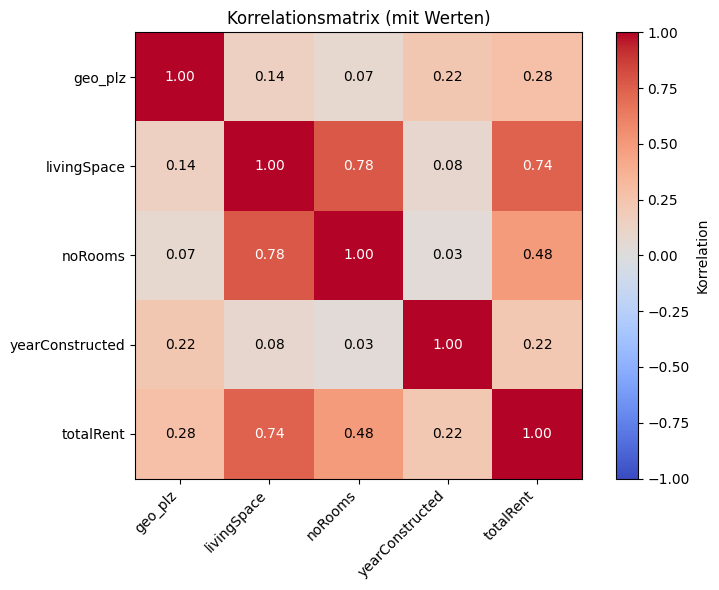

,geo_plz,livingSpace,noRooms,yearConstructed,totalRent
geo_plz,1.000000,0.141524,0.070733,0.220385,0.275389
livingSpace,0.141524,1.000000,0.776863,0.079314,0.735449
noRooms,0.070733,0.776863,1.000000,0.031909,0.484517
yearConstructed,0.220385,0.079314,0.031909,1.000000,0.216080
totalRent,0.275389,0.735449,0.484517,0.216080,1.000000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# nur numerische Spalten (aus deiner Liste)
corr_cols = ["geo_plz", "livingSpace", "noRooms", "yearConstructed", "totalRent"]
corr_cols = [c for c in corr_cols if c in df_logic.columns]

# numerisch machen
for c in corr_cols:
    df_logic[c] = pd.to_numeric(df_logic[c], errors="coerce")

# Korrelation berechnen
corr = df_logic[corr_cols].corr(method="pearson")  # oder "spearman"

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")  # andere Farben: "RdBu_r", "viridis", "plasma"

# Achsenbeschriftung
ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticklabels(corr_cols)

# Werte in die Zellen schreiben
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        val = corr.values[i, j]
        # Textfarbe je nach Hintergrund (damit lesbar)
        text_color = "white" if abs(val) > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Korrelation")

ax.set_title("Korrelationsmatrix (mit Werten)")
plt.tight_layout()
plt.show()

corr

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


# ----------------------------
# Settings
# ----------------------------
target = "totalRent"

num_features  = ["livingSpace", "noRooms", "yearConstructed", "date_days"]
cat_features  = ["geo_plz","street", "regio1", "regio2", "condition", "interiorQual", "typeOfFlat", "heatingType"]
bool_features = ["hasKitchen", "balcony", "garden", "cellar"]


# ----------------------------
# Data
# ----------------------------
dfp = df_logic.copy()

# keep only existing columns
num_features  = [c for c in num_features  if c in dfp.columns]
cat_features  = [c for c in cat_features  if c in dfp.columns]
bool_features = [c for c in bool_features if c in dfp.columns]

# target numeric
if target not in dfp.columns:
    raise KeyError(f"Target-Spalte '{target}' existiert nicht in df_logic.")

dfp[target] = pd.to_numeric(dfp[target], errors="coerce")
dfp = dfp.dropna(subset=[target]).copy()

# numeric cast -> float (missing = np.nan)
for c in num_features:
    dfp[c] = pd.to_numeric(dfp[c], errors="coerce").astype(float)

# categorical -> object
for c in cat_features:
    dfp[c] = dfp[c].astype("object")

# bool -> 0/1 int (robust gegen true/false/1/0/NaN)
for c in bool_features:
    s = dfp[c].astype("string").str.lower()
    dfp[c] = s.map({"true": 1, "false": 0}).fillna(dfp[c])
    dfp[c] = pd.to_numeric(dfp[c], errors="coerce").fillna(0).astype(int)

feature_cols = num_features + cat_features + bool_features
X_all = dfp[feature_cols].copy()

# pd.NA -> np.nan (sklearn-sicher)
X_all = X_all.replace({pd.NA: np.nan})

# y in Euro (KEIN LOG)
y_all = dfp[target].astype(float).values


# ----------------------------
# Holdout split (never in CV)
# ----------------------------
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_all, y_all, test_size=0.15, random_state=42
)
print("Train rows:", len(X_train), "Holdout rows:", len(X_holdout))


# ----------------------------
# Preprocess + Model (Simple)
# ----------------------------
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])


# ----------------------------
# 4-Fold CV on TRAIN only
# ----------------------------
kf = KFold(n_splits=4, shuffle=True, random_state=42)

oof_pred = np.empty(len(X_train), dtype=float)
fold_rows = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
    print(f"\n=== Fold {fold} START | train={len(tr_idx)} val={len(va_idx)} ===")

    X_tr = X_train.iloc[tr_idx].copy().replace({pd.NA: np.nan})
    X_va = X_train.iloc[va_idx].copy().replace({pd.NA: np.nan})
    y_tr = y_train[tr_idx]
    y_va = y_train[va_idx]

    pipe.fit(X_tr, y_tr)
    pred_va = pipe.predict(X_va)
    oof_pred[va_idx] = pred_va

    fold_mae = mean_absolute_error(y_va, pred_va)
    fold_r2  = r2_score(y_va, pred_va)

    fold_rows.append({"fold": fold, "MAE_EUR": fold_mae, "R2": fold_r2, "n_val": len(va_idx)})
    print(f"=== Fold {fold} END   | MAE(EUR)={fold_mae:.3f} | R2={fold_r2:.4f} ===")

fold_df = pd.DataFrame(fold_rows)
print("\nCV per-fold (TRAIN only):")
print(fold_df)

# OOF over TRAIN
print("\nOOF over TRAIN (Euro):")
print("MAE_OOF:", mean_absolute_error(y_train, oof_pred))
print("R2_OOF :", r2_score(y_train, oof_pred))


# ----------------------------
# Final fit on full TRAIN, evaluate once on HOLDOUT
# ----------------------------
print("\n=== FINAL FIT on full TRAIN, EVAL on HOLDOUT (once) ===")
pipe.fit(X_train.replace({pd.NA: np.nan}), y_train)
pred_ho = pipe.predict(X_holdout.replace({pd.NA: np.nan}))

print("MAE_HOLDOUT:", mean_absolute_error(y_holdout, pred_ho))
print("R2_HOLDOUT :", r2_score(y_holdout, pred_ho))



/tmp/ipython-input-819155656.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_all = X_all.replace({pd.NA: np.nan})


Train rows: 203327 Holdout rows: 35882

=== Fold 1 START | train=152495 val=50832 ===
=== Fold 1 END   | MAE(EUR)=117.058 | R2=0.8524 ===

=== Fold 2 START | train=152495 val=50832 ===
=== Fold 2 END   | MAE(EUR)=119.130 | R2=0.8487 ===

=== Fold 3 START | train=152495 val=50832 ===
=== Fold 3 END   | MAE(EUR)=119.921 | R2=0.8492 ===

=== Fold 4 START | train=152496 val=50831 ===
=== Fold 4 END   | MAE(EUR)=118.595 | R2=0.8503 ===

CV per-fold (TRAIN only):
   fold     MAE_EUR        R2  n_val
0     1  117.057657  0.852430  50832
1     2  119.129819  0.848735  50832
2     3  119.920971  0.849218  50832
3     4  118.595073  0.850344  50831

OOF over TRAIN (Euro):
MAE_OOF: 118.67588046089074
R2_OOF : 0.8501770076726193

=== FINAL FIT on full TRAIN, EVAL on HOLDOUT (once) ===
MAE_HOLDOUT: 116.55830791625785
R2_HOLDOUT : 0.8555815414840187


In [ ]:
X_one = pd.DataFrame([{
    "livingSpace": 50.0,
    "noRooms": 2,
    "yearConstructed": 2020,
    "date_days": 5849,
    "geo_plz": "85051",
    "regio1": "Bayern",
    "regio2": "Ingolstadt",
    "condition": "good",
    "interiorQual": "normal",
    "typeOfFlat": "apartment",
    "heatingType": "central_heating",
    "hasKitchen": 1,
    "balcony": 1,
    "garden": 0,
    "cellar": 1,

}])

pred_eur = pipe.predict(X_one)[0]
print(pred_eur)


771.5696076488805


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error


# =========================
# Settings
# =========================
target = "totalRent"

num_features  = ["livingSpace", "noRooms", "yearConstructed","date_days"]
cat_features  = ["geo_plz", "regio1", "regio2", "condition", "interiorQual", "typeOfFlat", "heatingType"]
bool_features = ["hasKitchen", "balcony", "garden", "cellar"]


# =========================
# Data
# =========================
dfp = df_logic.copy()

num_features  = [c for c in num_features  if c in dfp.columns]
cat_features  = [c for c in cat_features  if c in dfp.columns]
bool_features = [c for c in bool_features if c in dfp.columns]

dfp[target] = pd.to_numeric(dfp[target], errors="coerce")
dfp = dfp.dropna(subset=[target]).copy()

for c in num_features:
    dfp[c] = pd.to_numeric(dfp[c], errors="coerce").astype(float)

for c in cat_features:
    dfp[c] = dfp[c].astype("object")

for c in bool_features:
    s = dfp[c].astype("string").str.lower()
    dfp[c] = s.map({"true": 1, "false": 0}).fillna(dfp[c])
    dfp[c] = pd.to_numeric(dfp[c], errors="coerce").fillna(0).astype(int)

feature_cols = num_features + cat_features + bool_features
X_all = dfp[feature_cols].copy().replace({pd.NA: np.nan})
y_all = dfp[target].astype(float).values


# =========================
# Holdout split (never in CV)
# =========================
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_all, y_all, test_size=0.20, random_state=42
)
print("Train rows:", len(X_train), "Holdout rows:", len(X_holdout))


# =========================
# Preprocess + MLP model
# =========================
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)


mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),   # weniger tiefe Netze sind oft stabiler bei tabular
    activation="relu",
    solver="adam",
    alpha=1e-4,                         # L2-Regularisierung (wichtig bei OneHot)
    batch_size=2048,                    # größer bei vielen Daten
    learning_rate_init=1e-3,            # stabiler Start
    max_iter=300,                       # early stopping stoppt meist früher
    early_stopping=True,                # hilft gegen Overfitting
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
    verbose=True
)


pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", mlp)
])


# =========================
# 4-Fold CV on TRAIN only (MAE)
# =========================
kf = KFold(n_splits=4, shuffle=True, random_state=42)

oof_pred = np.empty(len(X_train), dtype=float)
fold_rows = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
    print(f"\n=== Fold {fold} START | train={len(tr_idx)} val={len(va_idx)} ===")

    X_tr = X_train.iloc[tr_idx].replace({pd.NA: np.nan})
    X_va = X_train.iloc[va_idx].replace({pd.NA: np.nan})
    y_tr = y_train[tr_idx]
    y_va = y_train[va_idx]

    pipe.fit(X_tr, y_tr)
    pred_va = pipe.predict(X_va)
    oof_pred[va_idx] = pred_va

    fold_mae = mean_absolute_error(y_va, pred_va)
    fold_rows.append({"fold": fold, "MAE_EUR": fold_mae, "n_val": len(va_idx)})

    print(f"=== Fold {fold} END   | MAE(EUR)={fold_mae:.3f} ===")

fold_df = pd.DataFrame(fold_rows)
print("\nCV per-fold (TRAIN only):")
display(fold_df)

print("\nOOF over TRAIN (Euro):")
print("MAE_OOF:", mean_absolute_error(y_train, oof_pred))


# =========================
# Final fit on full TRAIN, evaluate once on HOLDOUT
# =========================
print("\n=== FINAL FIT on full TRAIN, EVAL on HOLDOUT (once) ===")
pipe.fit(X_train.replace({pd.NA: np.nan}), y_train)
pred_ho = pipe.predict(X_holdout.replace({pd.NA: np.nan}))

print("MAE_HOLDOUT:", mean_absolute_error(y_holdout, pred_ho))


/tmp/ipython-input-4373221.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_all = dfp[feature_cols].copy().replace({pd.NA: np.nan})


Train rows: 191367 Holdout rows: 47842

=== Fold 1 START | train=143525 val=47842 ===
Iteration 1, loss = 414439.73068701
Validation score: -2.017560
Iteration 2, loss = 146873.43123611
Validation score: 0.606280
Iteration 3, loss = 37359.79692865
Validation score: 0.754419
Iteration 4, loss = 25843.52349029
Validation score: 0.815769
Iteration 5, loss = 20926.90334899
Validation score: 0.841023
Iteration 6, loss = 18785.19491740
Validation score: 0.852969
Iteration 7, loss = 17669.86667752
Validation score: 0.859377
Iteration 8, loss = 17007.35591797
Validation score: 0.863596
Iteration 9, loss = 16564.36505723
Validation score: 0.866261
Iteration 10, loss = 16264.36315026
Validation score: 0.868184
Iteration 11, loss = 16018.94525636
Validation score: 0.869733
Iteration 12, loss = 15824.23336543
Validation score: 0.871248
Iteration 13, loss = 15666.17743860
Validation score: 0.872244
Iteration 14, loss = 15496.50620677
Validation score: 0.873060
Iteration 15, loss = 15363.95873771
Va

,fold,MAE_EUR,n_val
0,1,96.158558,47842
1,2,95.536768,47842
2,3,95.997275,47842
3,4,96.226415,47841



OOF over TRAIN (Euro):
MAE_OOF: 95.9797526834757

=== FINAL FIT on full TRAIN, EVAL on HOLDOUT (once) ===
Iteration 1, loss = 383572.33033727
Validation score: -0.608400
Iteration 2, loss = 61232.40546770
Validation score: 0.706178
Iteration 3, loss = 27509.80439628
Validation score: 0.803690
Iteration 4, loss = 20603.46118466
Validation score: 0.835824
Iteration 5, loss = 18197.70717554
Validation score: 0.848796
Iteration 6, loss = 17092.10724903
Validation score: 0.855738
Iteration 7, loss = 16475.05358073
Validation score: 0.859678
Iteration 8, loss = 16071.33463198
Validation score: 0.862400
Iteration 9, loss = 15780.17719004
Validation score: 0.864203
Iteration 10, loss = 15567.21712281
Validation score: 0.865729
Iteration 11, loss = 15379.37195625
Validation score: 0.867474
Iteration 12, loss = 15212.23104186
Validation score: 0.868940
Iteration 13, loss = 15079.16758263
Validation score: 0.869989
Iteration 14, loss = 14930.69695488
Validation score: 0.871086
Iteration 15, loss

In [ ]:
X_one = pd.DataFrame([{
    "livingSpace": 50.0,
    "noRooms": 2,
    "yearConstructed": 2020,
    "date_days": 5849,
    "geo_plz": "07745",
    "regio1": "Thüringen",
    "regio2": "Jena",
    "condition": "good",
    "interiorQual": "normal",
    "typeOfFlat": "apartment",
    "heatingType": "central_heating",
    "hasKitchen": 1,
    "balcony": 1,
    "garden": 0,
    "cellar": 1,

}])

pred_eur = pipe.predict(X_one)[0]
print(pred_eur)

784.0694657985975


In [ ]:
import joblib

# pipe ist deine trainierte Pipeline (pipe.fit(...) wurde gemacht)
joblib.dump(pipe, "pipeline_lr.joblib")


['pipeline_lr.joblib']